# Clustering Project Notebook

![Image of Zillow Logo](https://www.roundtablerealty.com/uploads/agent-1/699119.png)




### Zillow: What is driving the errors in the Zestimates?
#### Background:
 Zillow, a real estate website in the United States, uses a Zestimate to estimate a property's market value.
> What is a Zestimate?     & 
How is the Zestimate calculated? - zillow.com

> For this project, we will look into finding drivers of error in the Zestimate. Using clustering methodologies, feature identification and comparison, visualizations, statistical testing, and regression models, we are to find drivers of error to predict log error.

### Project Goals:
 - Using Zillow data for single unit/single family homes sold in 2017, find drivers of log error in the Zestimate.

 - Create 4 regression models to predict log error

 - Use clustering methodologies to help identify drivers of log error

 - Deliver findings in a final Jupyter Notebook presentation

## Executive Summary:
#### Findings Include:
#### Takeaways:
#### Next Steps to Explore Further:

In [14]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve
import env

# supress scientific notation
np.set_printoptions(suppress=True)

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import wrangle

In [15]:
df = wrangle.get_zillow_data()

In [16]:
df.head()

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value,logerror
0,4.0,3.5,3100.0,1998.0,96978.0,6059.0,1023282.0,0.025595
1,2.0,1.0,1465.0,1967.0,97099.0,6111.0,464000.0,0.055619
2,3.0,2.0,1243.0,1962.0,97078.0,6059.0,564778.0,0.005383
3,4.0,3.0,2376.0,1970.0,96330.0,6037.0,145143.0,-0.103410
4,4.0,3.0,2962.0,1950.0,96293.0,6037.0,773303.0,-0.001011


## Data Acquisition / Prep / Wrangling Takeaways:
 - Created and used functions in wrangle.py to acquire and prep data

 - Used a SQL query to join 7 tables

 - Selected only single family properties filtered by:
   - Properties with propertylandusetypeid = 261
   - Only retrieving latest transaction date, eliminating duplicates sold more than once in same year
   - Only selecting properties with at least 1 bath & bed and 350 sqft area
   - Only properties with a latitude and longitude that is not null
   - Dropping columns that are less than 70% populated, mostly empty columns
   - Adding a 'county' column based on FIPS unique county identifier feature
   - Dropping columns that are not useful features or redundant
   - Filling null values in unitcnt column with 1 since all are single unit properties
   - Replacing nulls with median values for select columns:
     - 7313 for lotsizesquarefeet
     - 6.0 for buildingqualitytypeid -Since this is Southern CA, filling null with 'None' for heatingorsystemdesc because most likely don't have one -Rename columns for easier readability -Removed outliers based on Inter Quartile Rule for properties with outliers in square footage, price, bedrooms, and bathrooms

____

# Explore

In [17]:
df.shape

(52442, 8)

In [18]:
df.head()

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value,logerror
0,4.0,3.5,3100.0,1998.0,96978.0,6059.0,1023282.0,0.025595
1,2.0,1.0,1465.0,1967.0,97099.0,6111.0,464000.0,0.055619
2,3.0,2.0,1243.0,1962.0,97078.0,6059.0,564778.0,0.005383
3,4.0,3.0,2376.0,1970.0,96330.0,6037.0,145143.0,-0.103410
4,4.0,3.0,2962.0,1950.0,96293.0,6037.0,773303.0,-0.001011


In [19]:
# Check to see if nulls were removed
wrangle.nulls_by_col(df)

,num_rows_missing,percent_rows_missing
bedrooms,0,0.000000
bathrooms,0,0.000000
squarefeet,82,0.156363
year_built,116,0.221197
regionidzip,26,0.049579
fips,0,0.000000
tax_value,1,0.001907
logerror,0,0.000000


In [20]:
wrangle.nulls_by_row(df)

,num_cols_missing,percent_cols_missing,index
0,0,0.0,52301
1,1,12.5,60
2,2,25.0,78
3,3,37.5,3


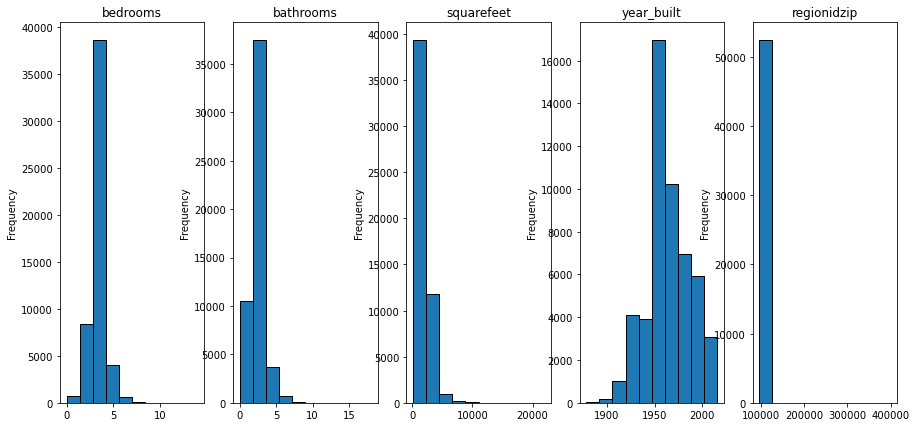

In [21]:
# Plot the distribution of some numeric variables
fig, axs = plt.subplots(1, 5, figsize=(15, 7))

for ax, col in zip(axs, df.select_dtypes('number')):
    df[col].plot.hist(ax=ax, title=col, ec='black')

In [22]:
# Binning square footage for comparison and visualization purposes
df['sq_ft_bins'] = pd.cut(df.squarefeet, [0, 1000, 2000,3000,4000, 10000])
df.head()

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value,logerror,sq_ft_bins
0,4.0,3.5,3100.0,1998.0,96978.0,6059.0,1023282.0,0.025595,"(3000, 4000]"
1,2.0,1.0,1465.0,1967.0,97099.0,6111.0,464000.0,0.055619,"(1000, 2000]"
2,3.0,2.0,1243.0,1962.0,97078.0,6059.0,564778.0,0.005383,"(1000, 2000]"
3,4.0,3.0,2376.0,1970.0,96330.0,6037.0,145143.0,-0.103410,"(2000, 3000]"
4,4.0,3.0,2962.0,1950.0,96293.0,6037.0,773303.0,-0.001011,"(2000, 3000]"


In [28]:
# Binning transactiondate for comparison and visualization purposes
df['years_old'] = 2017 - df['year_built']
#df['year_bins'] = pd.cut(df.years_old, [0,3,6,9,12])

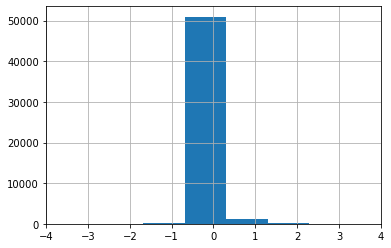

In [31]:
# A look at logerror:
df.logerror.hist()
plt.xlim(-4, 4);

In [32]:
df.logerror.max(), df.logerror.min(), df.logerror.mean(), df.logerror.median()

(5.2629986498, -4.65542037764, 0.018294374445429716, 0.00700998395102)

In [51]:
# Before exploring data further, we'll need to split data into train, validate and test, 
# so that we only explore on train. The data was split with 'wrangle.wrangle_zillow()'
wrangle.wrangle_zillow()
train.shape, validate.shape, test.shape

((29367, 11), (12586, 11), (10489, 11))

In [52]:
#Let's look at how variables are correlated
corr =  train.corr(method='pearson')

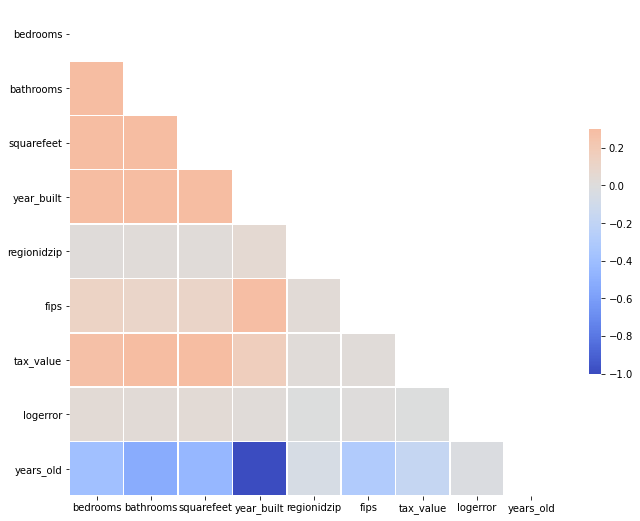

In [53]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

### My first question:
## Does log error differ across square feet?

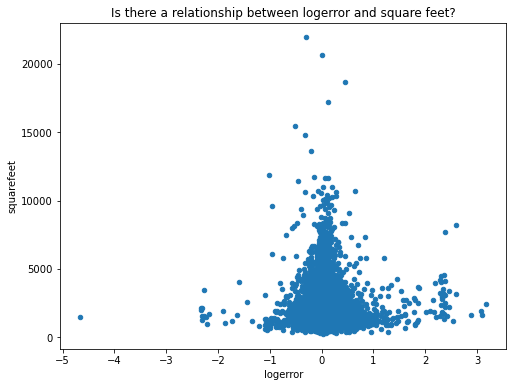

In [54]:
# Let's look at the relationship between log error and square feet
train.plot.scatter(
    x="logerror",
    y="squarefeet",
    title='Is there a relationship between logerror and square feet?',
    figsize=(8, 6),
);

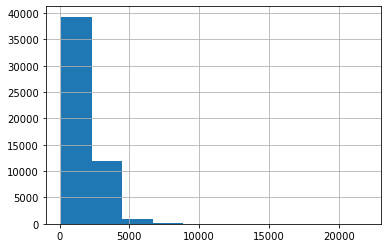

In [55]:
# Distribution of square footage 
df.squarefeet.hist();

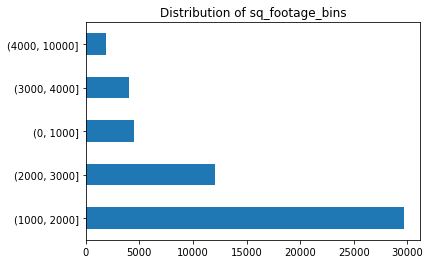

In [56]:
# Distribution of square footage by bins
# Looks like most properties are between 1,000-2,000 square feet

df.sq_ft_bins.value_counts().plot.barh(title='Distribution of sq_footage_bins');

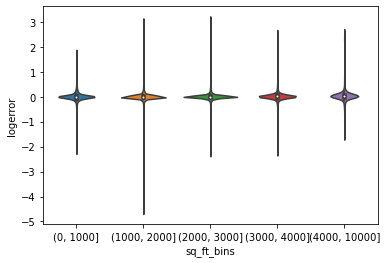

In [57]:
# Let's look at how log error compares across square footage by bins
# It doesn't look like there's much difference 
sns.violinplot(data=train, y='logerror', x='sq_ft_bins');

## Levene's Test: test for equal variance
$Ho$: There is no difference in logerror variance between the square footage

$Ha$: There is a difference in logerror variance between the square footage

In [58]:
stats.levene(
    train[train.squarefeet <= 1000].logerror,
    train[train.squarefeet > 1000].logerror,
)

LeveneResult(statistic=69.16068193275763, pvalue=9.464248383416298e-17)

In [59]:
stats.levene(
    train[train.squarefeet <= 2000].logerror,
    train[train.squarefeet > 2000].logerror,
)

LeveneResult(statistic=0.005548032197644679, pvalue=0.9406248937963714)

In [60]:
stats.levene(
    train[train.squarefeet <= 3000].logerror,
    train[train.squarefeet > 3000].logerror,
)

LeveneResult(statistic=55.32279695558132, pvalue=1.0507466315548768e-13)

In [61]:
stats.levene(
    train[train.squarefeet <= 4000].logerror,
    train[train.squarefeet > 4000].logerror,
)

LeveneResult(statistic=67.21838151083908, pvalue=2.5285670279986825e-16)

### Create independent statistical tests to check for dependency amongst variables

In [62]:
stats.ttest_ind(
    train[train.squarefeet <= 1000].logerror,
    train[train.squarefeet > 1000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-0.6641348604435102, pvalue=0.5066559199716268)

In [63]:
stats.ttest_ind(
    train[train.squarefeet <= 2000].logerror,
    train[train.squarefeet > 2000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-4.9683137328205325, pvalue=6.811403586140173e-07)

In [64]:
stats.ttest_ind(
    train[train.squarefeet <= 3000].logerror,
    train[train.squarefeet > 3000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-5.718998280265392, pvalue=1.152443287295637e-08)

In [65]:
stats.ttest_ind(
    train[train.squarefeet <= 4000].logerror,
    train[train.squarefeet > 4000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-4.161267030237608, pvalue=3.40699053788035e-05)

### Conclusion:
We reject the null hypothesis that the logerror is the same for all square footages.

-----

### Hypothesis :
$Ho$ : Null Hypothesis: There is no correlation between square footage and log error .

$Ha$ : Alternative Hypothesis: Square footage and log error are correlated.

In [69]:
train = train.dropna()
test = test.dropna()
validate = validate.dropna()

In [70]:
x = train.squarefeet
y = train.logerror

In [71]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.08878466225519296, 0.0021818362409912083)

In [72]:
# Null hypothesis is rejected.  Square footage and log error are correlated.

### My second question: 
## Does log error differ across county?

In [73]:
df.head()

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value,logerror,sq_ft_bins,years_old,year_bins
0,4.0,3.5,3100.0,1998.0,96978.0,6059.0,1023282.0,0.025595,"(3000, 4000]",19.0,NaN
1,2.0,1.0,1465.0,1967.0,97099.0,6111.0,464000.0,0.055619,"(1000, 2000]",50.0,NaN
2,3.0,2.0,1243.0,1962.0,97078.0,6059.0,564778.0,0.005383,"(1000, 2000]",55.0,NaN
3,4.0,3.0,2376.0,1970.0,96330.0,6037.0,145143.0,-0.103410,"(2000, 3000]",47.0,NaN
4,4.0,3.0,2962.0,1950.0,96293.0,6037.0,773303.0,-0.001011,"(2000, 3000]",67.0,NaN


In [74]:
# Look at how counties compare in number
### 6037 = Los Angeles County
### 6059 = Orange County
### 6111 = Ventura County
df.fips.value_counts()

6037.0    33911
6059.0    14136
6111.0     4395
Name: fips, dtype: int64

In [ ]:
df['county'] = 

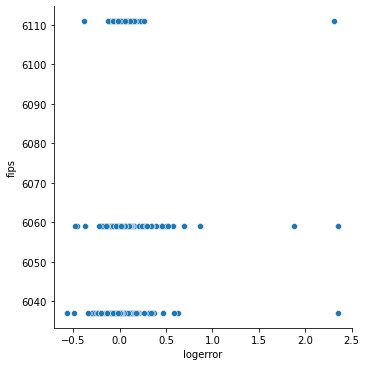

In [75]:
#Look at how log error compares amongst counties
sns.relplot(data=train, x='logerror', y='fips')